# Practical 2.  Baseline Models

In this practical will apply our knowledge in

* Creating baseline forecasts
* Performing a train-test split
* Using forecast error metrics MAE and MAPE to select the best method 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

In [2]:
#baseline forecast methods
from forecast.baseline import (Naive1, 
                               SNaive,
                               Drift,
                               Average,
                               baseline_estimators)

from forecast.metrics import mean_absolute_percentage_error

In [3]:
#helper functions
def preds_as_series(data, preds):
    '''
    Helper function for plotting predictions.
    Converts a numpy array of predictions to a 
    pandas.DataFrame with datetimeindex
    
    Parameters
    -----
    data - arraylike - the training data
    preds - numpy.array, vector of predictions 
    '''
    start = pd.date_range(start=data.index.max(), periods=2, freq=data.index.freq).max()
    idx = pd.date_range(start=start, periods=len(preds), freq=data.index.freq)
    return pd.DataFrame(preds, index=idx)

## Exercise 1: Using Naive1 to forecast Nile River Flow

**Step 1: Import Nile river flow data.**  

This can be found in **"data/nile.csv"**

* Hint: this is yearly data.  You can use the Annual Start ('AS') frequency

In [4]:
nile = pd.read_csv('data/nile.csv', index_col='year', parse_dates=True)
nile.index.freq = 'AS'

**Step 2 Plot the Nile data**

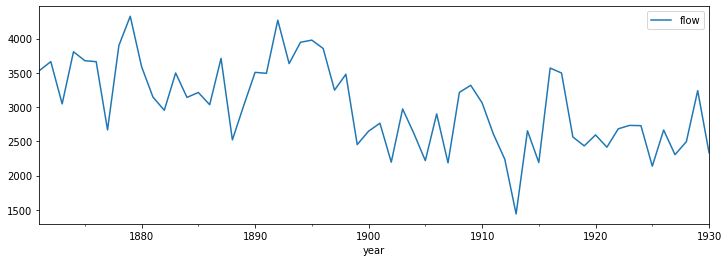

In [5]:
nile.plot(figsize=(12,4))

**Step 3: Create and fit Naive1 forecast model**

* Hint: you want to fit `nile['flow']`

In [6]:
nf1 = Naive1()
nf1.fit(nile['flow'])

**Step 4: Plot the Naive1 fitted values**

All the baseline models have fitted values.  These are the in-sample prediction i.e. the predictions of the training data.

Once you have created and fitted a Naive1 model you can access the fitted values using the `.fittedvalues` property.  This returns a `DataFrame`.

Plot the fitted values against the observed data.

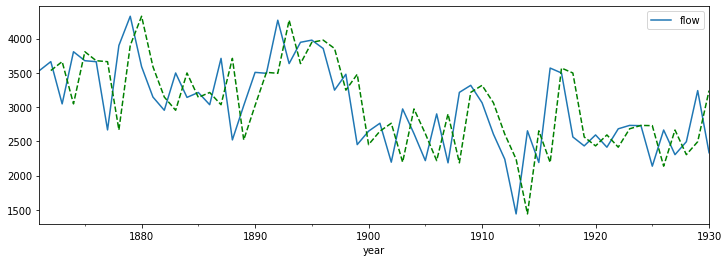

In [7]:
ax = nile.plot(figsize=(12,4))
nf1.fittedvalues.plot(ax=ax, color='green', linestyle='--')

**Step 5: Forecast the next 5 years**

After you have created a forecast plot the predictions.  

* Hint: use the `pred_as_series()` method to plot the predictions.  See the lecture notes for exampes of how to use it.

In [8]:
preds = nf1.predict(horizon=6)

In [9]:
preds = preds_as_series(nile, preds)

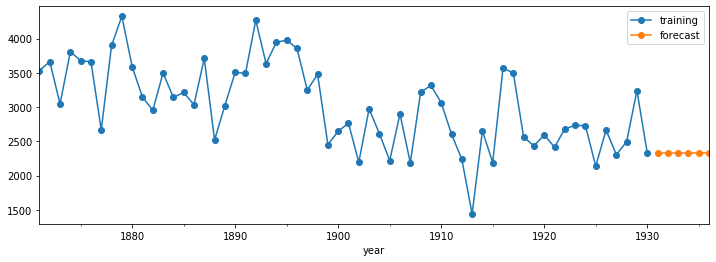

In [10]:
ax = nile.plot(figsize=(12,4), marker='o')
preds.plot(ax=ax, marker='o')
ax.legend(['training', 'forecast'])

## Exercise 2. Choose the best baseline forecast method for ED reattendances

**Step 1: Import emergency department reattendance data.**  

This is a time series from a hospital that measures the number of patients per month that have reattended an ED within 7 days of a previous attendance.

This can be found in **"data/ed_reattend.csv"** 

* Hint 1: The format of the 'date' column is in UK standard dd/mm/yyyy.  You will need to set the `dayfirst=True` of `pd.read_csv()` to make sure pandas interprets the dates correctly.

* Hint 2: The data is monthly and the dates are all the first day of the month.  This is called monthly start and its shorthand is 'MS'

In [11]:
reattends = pd.read_csv('data/ed_reattend.csv', index_col='date', 
                        parse_dates=True, dayfirst=True)
reattends.index.freq = 'MS'

**Step 2: Perform a calender adjustment**

In [12]:
reattend_rate = reattends['reattends'] / reattends.index.days_in_month

**Step 3: Perform a train-test split**

Create a train test split where you holdback the final 6 months of the data.

Remember to work with the calender adjusted data.

In [13]:
train = reattend_rate.iloc[:-6]
test = reattend_rate.iloc[-6:]

In [14]:
train.shape

(37,)

In [15]:
test.shape

(6,)

**Step 4: Plot the TRAINING data**

Remember don't look at the test data just yet.  You don't want to bias your model selection process.

Text(0, 0.5, 'mean reattends within 7 days')

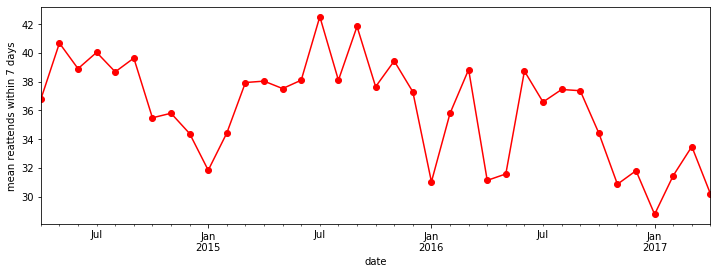

In [16]:
ax = train.plot(figsize=(12,4), color='red', marker='o', legend=False)
ax.set_ylabel('mean reattends within 7 days')

**Step 5: Create and fit Naive1, SNaive, Average, Drift and Ensemble baseline models**

* Hint: remember that the `baseline_estimators()` function will create all of these objects for you and return them in a dict.  

* Hint: Fit the TRAINING data.

In [17]:
models = baseline_estimators(seasonal_periods=12)

In [18]:
models

{'NF1': <forecast.baseline.Naive1 at 0x1a1707ac18>,
 'SNaive': <forecast.baseline.SNaive at 0x1a173199b0>,
 'Average': <forecast.baseline.Average at 0x1a17319860>,
 'Drift': <forecast.baseline.Drift at 0x1a173198d0>,
 'Ensemble': <forecast.baseline.EnsembleNaive at 0x1a1730a278>}

In [19]:
for model_name, model in models.items():
    model.fit(train)

**Step 6: Use each model to predict 6 months ahead**

* Hint.  You need to store the prediction results so that later on you can calculate the forecast error.

In [20]:
preds = {}
for model_name, model in models.items():
    preds[model_name] = model.predict(horizon=6)

**Step 7: Calculate the mean absolute error of each forecast method**
    
Based on the results which method would you choose?

In [24]:
print('MAE\n-----')
for model_name, model_preds in preds.items():
    mae = mean_absolute_error(y_true=test, y_pred=model_preds)
    print(f'{model_name}: {mae}')

MAE
-----
NF1: 1.8876344086021497
SNaive: 7.152688172043011
Average: 7.199576964538029
Drift: 1.4316158900836307
Ensemble: 4.09378238330894


**Step 8: Calculate the out of sample MAPE of each forecast method**
    
Would you still choose the same forecasting method?

Is it useful to calculate both metrics?

In [25]:
print('MAPE\n-----')
for model_name, model_preds in preds.items():
    mae = mean_absolute_percentage_error(y_true=test, y_pred=model_preds)
    print(f'{model_name}: {mae}')

MAPE
-----
NF1: 6.697481885215069
SNaive: 25.101923992830628
Average: 25.345322850255585
Drift: 5.010458453801927
Ensemble: 14.5218948986897
